Import All Libraries

In [1]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

ModuleNotFoundError: No module named 'torch'

In [2]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [3]:
#Fuction for random colours used to represent mask object
def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

In [4]:
#Coco dataset Label
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [5]:
def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class, pred


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls, pred = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask_dict = {}
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,(pred_cls[i] + " " + str(i) ), boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    mask_dict.update({i:pred_cls[i]})
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  result = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  return result, mask_dict


In [6]:

def getFrame(sec, target_height, target_width, vidcap):
    fr_lst = []
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2RGB)
        fr_lst.append(cv2.resize(image, (target_width, target_height)))
    return hasFrames, fr_lst

    
## Build a function that takes a video path, ingests that video, converts it to frames and then returns the frames to you
def convert_vid_to_frames(video_path, FPS, target_height, target_width):
    vidcap = cv2.VideoCapture(video_path)
    sec = 0 #start location of where we want to start 
    frameRate = 1/FPS #//it will capture image in each 0.5 second
    count=1
    frame_list = []
    success, fr_lst = getFrame(sec, target_height, target_width, vidcap)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success, fr_lst = getFrame(sec, target_height, target_width, vidcap)
        try:
            frame_list.append(fr_lst[0])
        except:
            pass
        if len(frame_list) > 360:
            print('Too many frames')
            break
    return frame_list.copy()

def generate_gif_arrays(video_path, gif_height, gif_width, FPS):
    gif_frame_list = convert_vid_to_frames(video_path, FPS, gif_height, gif_width)
    return gif_frame_list

def generate_video(frames_list, video_height, video_width, video_output_path, FPS):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_output_path, fourcc, float(FPS), (video_width, video_height))
    video_seconds = int(len(frames_list)/FPS)
#     print('The video is %s seconds long' % video_seconds)
    # Get updates at increments of 20% completion
    twenty_perc = len(frames_list)/5
    for i in range(len(frames_list)):
        val = i%twenty_perc
        if val < 1:
            perc = int(i/twenty_perc) * 20
#             print('%s %% Done' % perc)
        frame = frames_list[i]
        frame = changeBackground(frame, ini_mask,1)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        try:
            video.write(frame)
        except:
#             print('error')
            continue
#     print('100 %% Done')
    video.release()


In [35]:
def get_mask(frame, pickedObject):
  transform = T.Compose([T.ToTensor()])
  img = Image.fromarray(frame)
  img = transform(img)
  pred = model([img])
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  gmask = Image.fromarray(masks[pickedObject])
  return (gmask)

def mask_mean(mask1, mask2):
  mask1 = np.mean(mask1)
  mask2 = np.mean(mask2)
  result = ((mask2-mask1)/mask1)
  return result

def changeBackground(frame, pickedObject):
  transform = T.Compose([T.ToTensor()])
  img = Image.fromarray(frame)
  img = transform(img)
  pred = model([img])
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  blend = Image.fromarray(frame)
  blend2 = Image.fromarray(frame)
  gmask = Image.fromarray(masks[pickedObject])
  background = Image.new("L", blend.size, 255)
  blend2.putalpha(gmask)
  im = Image.composite(blend2, background, gmask)
  return im


def Gif_changer(path, fps, width, height):
    masked_frame = []
    frames = convert_vid_to_frames(path, fps, height, width)
    for frame in frames:
      try:
        changed_mask = changeBackground(frame, 0)
        masked_frame.append(changed_mask)
      except:
        continue

    return masked_frame

In [17]:
def video_size(path):
  vidcap = cv2.VideoCapture(path)
  width = int(vidcap.get(3))
  height = int(vidcap.get(4))
  fps = vidcap.get(5)
  return width, height, fps

In [10]:
!wget "https://media.giphy.com/media/PoImGf3Takz1BtpNSG/giphy.mp4"

--2020-07-25 22:22:08--  https://media.giphy.com/media/PoImGf3Takz1BtpNSG/giphy.mp4
Resolving media.giphy.com (media.giphy.com)... 151.101.250.2
Connecting to media.giphy.com (media.giphy.com)|151.101.250.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887546 (1.8M) [video/mp4]
Saving to: ‘giphy.mp4’

giphy.mp4           100%[===================>]   1.80M  8.79MB/s    in 0.2s    

2020-07-25 22:22:09 (8.79 MB/s) - ‘giphy.mp4’ saved [1887546/1887546]



In [18]:
video_size("giphy.mp4")

(480, 480, 12.5)

In [19]:
frame_test = convert_vid_to_frames("giphy.mp4", 60, 480, 480)

In [ ]:
pathin = 'giphy.mp4'
pathout = 'video.avi'
fps = 0.5


In [ ]:
def convert_frames_to_vid():
    

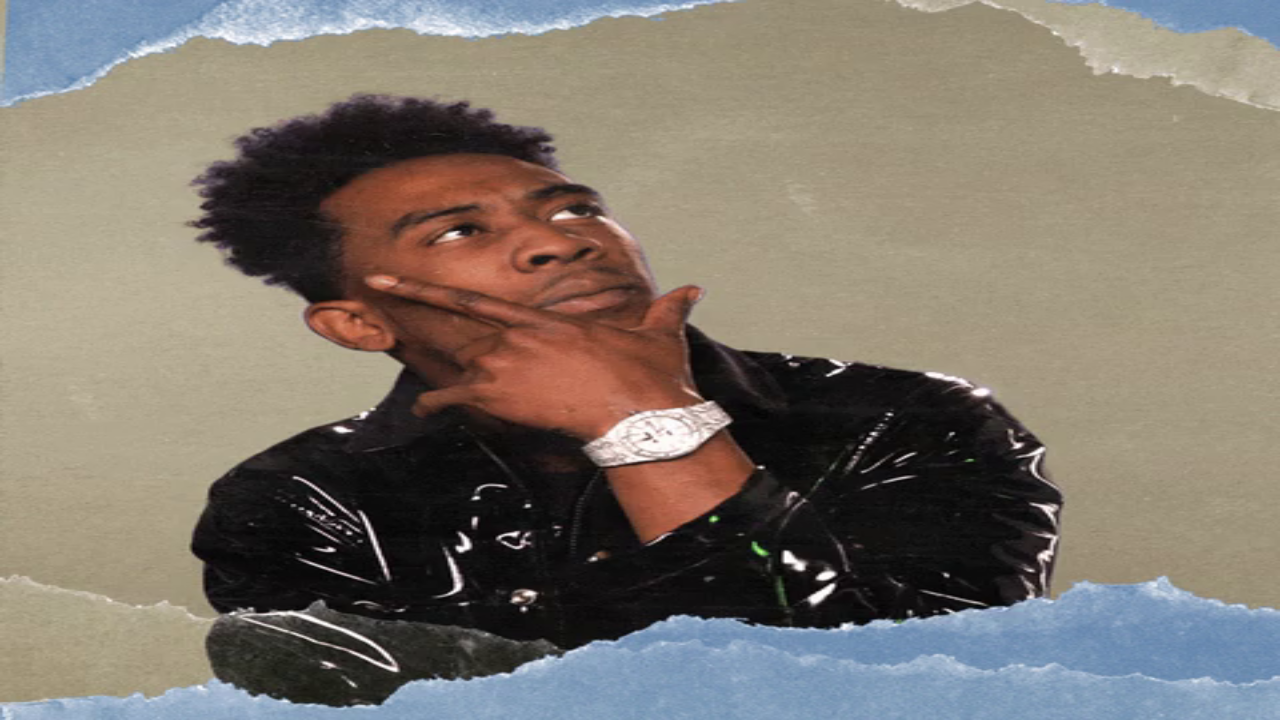

In [15]:
Image.fromarray(frame_test[0])

In [22]:
 mask = get_mask(frame_test[0], 0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


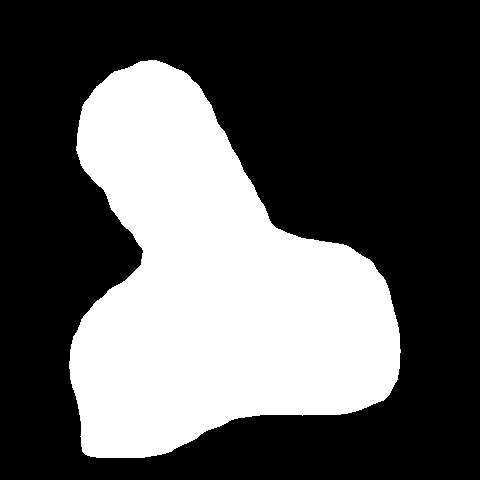

In [23]:
mask

In [33]:
len(frame_test)

217

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


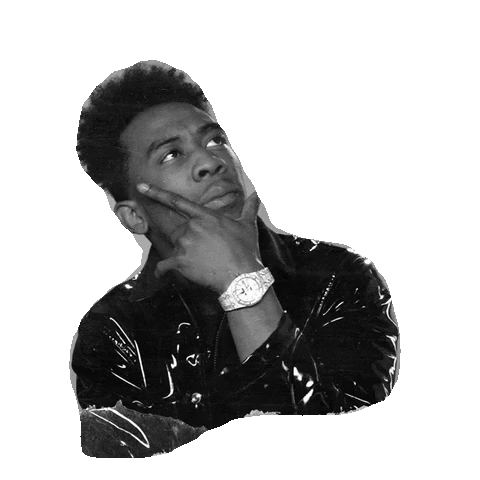

In [34]:
output = changeBackground(frame_test[0], 0)

In [36]:
Gif_changer("giphy.mp4", 60, 480, 480)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


[<PIL.Image.Image image mode=L size=480x480 at 0x7F960C0C9278>,
 <PIL.Image.Image image mode=L size=480x480 at 0x7F960C106D68>,
 <PIL.Image.Image image mode=L size=480x480 at 0x7F960C1068D0>,
 <PIL.Image.Image image mode=L size=480x480 at 0x7F960C106DA0>,
 <PIL.Image.Image image mode=L size=480x480 at 0x7F960C106C88>]